# Import Libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
import spacy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, precision_recall_curve, cohen_kappa_score, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [55]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('cmudict')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Data Load

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/preprocessed_dataset.csv', dtype=str)

In [58]:
df

,text,label
0,feel realli helpless heavi heart,fear
1,ive enjoy abl slouch relax unwind frank need l...,sadness
2,gave internship dmrg feel distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thorough weari job taken ...,fear
...,...,...
416118,feel like tell horni devil find site suit sort...,love
416119,began realiz feel agit restless would thought ...,anger
416120,feel curious previous earli dawn time seek troubl,surprise
416121,feel becuas tyran natur govern el salvador sav...,anger


# Data Split

What Are We Doing?

1. **Mapping Labels:** Converting emotional categories like 'sadness' and 'joy' into numerical values (e.g., 0 for sadness, 1 for joy) for compatibility with machine learning models.
2. **Splitting Data:** Dividing the dataset into training (90%) and testing (10%) sets to train the model and evaluate its performance.

Why Are We Doing This?
1. **Mapping Labels:** Machine learning models require numerical inputs, making this conversion essential for processing.
2. **Data Split:** Separating data ensures the model learns patterns from one subset and is evaluated on unseen data, avoiding overfitting and ensuring unbiased performance measurement.

**Result:**
The dataset is ready for training, with numerical labels and a proper train-test split, ensuring the model is evaluated fairly.

In [59]:
# Map the emotional categories in the 'label' column back to numerical labels
df['label'] = df['label'].map({
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
})
df

,text,label
0,feel realli helpless heavi heart,4
1,ive enjoy abl slouch relax unwind frank need l...,0
2,gave internship dmrg feel distraught,4
3,dont know feel lost,0
4,kindergarten teacher thorough weari job taken ...,4
...,...,...
416118,feel like tell horni devil find site suit sort...,2
416119,began realiz feel agit restless would thought ...,3
416120,feel curious previous earli dawn time seek troubl,5
416121,feel becuas tyran natur govern el salvador sav...,3


In [60]:
# Train-Test Split
X = df['text']
y = df['label']

# Splitting the dataset: first 90% for training, last 10% for testing
split_index = int(0.9 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (374510,)
The shape of X_test is  (41613,)
The shape of y_train is (374510,)
The shape of y_test is (41613,)


# Tokenizer

What Are We Doing?
* **Tokenization:** We are using the Tokenizer to convert text into tokens (words) and limiting the vocabulary to the top 70,000 words. Words outside this range are replaced with an 'UNK' (unknown) token.
* **Sequence Conversion:** The text is transformed into numerical sequences where each word is represented by its index in the vocabulary.
* **Max Sequence Length:** We calculate the longest sequence in the training data to determine the maximum length (maxlen) for padding the sequences uniformly.

Why Are We Doing This?
1. **Tokenization:** Converts text into numerical data that can be processed by machine learning models.
2. **Limiting Vocabulary Size:** Reduces complexity and ensures the model focuses on the most important words.
3. **Sequence Conversion:** Preserves the order of words, which is essential for understanding context in text.
4. **Max Sequence Length:** Helps in padding or truncating sequences to a consistent length for model input.

Why Is This Important?

This process prepares the text data for model training by converting it into a numerical format, ensuring consistent input size, and optimizing efficiency for the model.

In [61]:
vocab_sz = 70000
tokenizer = Tokenizer(num_words=vocab_sz, oov_token='UNK')
X_train = X_train.astype(str)
X_test = X_test.astype(str)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [62]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Perform Padding

What Are We Doing?

We are performing padding on the sequences of both the training and test data. Padding ensures that all sequences in the dataset have the same length, which is crucial for input into neural networks. Sequences that are shorter than the maxlen are padded with zeros at the end (padding='post').

Why Are We Doing This?
1. **Uniform Input Length:** Neural networks require input sequences to be of the same length. Padding helps achieve this by extending shorter sequences to the maxlen.
2. **Handling Variable-Length Sequences:** Text data can have varying lengths. Padding standardizes the length of all sequences, preventing issues during model training.

Why Is This Important?

Padding ensures that the model receives data in a consistent format, making the training process efficient and preventing errors caused by differing input lengths. It allows the model to handle sequences of varying lengths without bias toward longer or shorter texts.

In [63]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [64]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [65]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[   2  190   69 ...    0    0    0]
 [  48  512  214 ...    0    0    0]
 [   2   66   74 ...    0    0    0]
 ...
 [2170 1073  325 ...    0    0    0]
 [   5    5   80 ...    0    0    0]
 [   2   16    3 ...    0    0    0]]

X_test_padded:
[[  111     2   159 ...     0     0     0]
 [  159 16504  4001 ...     0     0     0]
 [   55     2     3 ...     0     0     0]
 ...
 [   16     2   452 ...     0     0     0]
 [    2  2402    32 ...     0     0     0]
 [    2  2175   612 ...     0     0     0]]


# BiLSTM

BiLSTM (Bidirectional Long Short-Term Memory) is an extension of the LSTM (Long Short-Term Memory) model, which processes data in both forward and backward directions. While traditional LSTMs process the input sequence from the start to the end, BiLSTM processes it in both directions forward (past to future) and backward (future to past). This allows the model to capture context from both the past and the future of a word in the sequence, improving its ability to understand the meaning of words based on surrounding context.

Why Choose BiLSTM for Emotion Detection?
BiLSTM is particularly effective for emotion detection in text for several reasons:

1. **Capturing Context from Both Directions:** Emotions in text often rely on both the preceding and following words to fully understand the emotional tone. BiLSTM captures contextual information from both the past and future, which provides a more comprehensive understanding of the sentence and enhances the accuracy of emotion detection.

2. **Improved Contextual Understanding:** By considering both forward and backward contexts, BiLSTM can detect subtle emotional cues that may be influenced by words coming after the current word, or by the previous words. This helps in capturing nuances in sentiment and emotion that might be missed by a traditional LSTM.

3. **Better Performance on Complex Sentences:** In sentences where the emotion is conveyed by words near the end or beginning, BiLSTM’s bidirectional nature helps in understanding the emotional context from both ends, making it more powerful than a unidirectional LSTM.

In summary, BiLSTM is an excellent choice for emotion detection because it captures a richer context from both directions in the text, allowing the model to more accurately understand the emotional meaning of the text.

## Hyper Parameter

What Are We Doing?

1. **Batch Size and Epochs:** We define how many samples to process at once (32) and how many times the model will train on the entire dataset (15).
2. **Early Stopping:** We set up early stopping to halt training if the validation accuracy doesn't improve for 10 epochs, avoiding overfitting.
3. **Embedding Size:** We set the embedding size to match the number of unique words in the dataset.
4. **Label Encoding:** Convert categorical labels (emotions) into numeric values.
5. **Number of Classes:** We determine the number of unique classes (emotions) for model output.

Why Is This Important?

**Batch Size and Epochs:** Control training efficiency.

**Early Stopping:** Prevents overfitting.

**Label Encoding:** Makes labels machine-readable.

**Number of Classes:** Helps configure the output layer of the model.

In [66]:
batch_size = 64
epochs = 10
earlyStopping = [EarlyStopping(monitor='val_accuracy',patience = 3 ,mode='max')]
embedding_size = len(tokenizer.word_index) + 1
input_size = np.max(X_train_padded) + 1
n_classes = 6
output_dim = 100

## Build Model

**1. Define the Model**


`model = Sequential()` initializes a sequential model, where layers are added one by one in a linear fashion.

**2. Add an Embedding Layer**

   
`model.add(Embedding(input_dim=input_size, output_dim=output_dim, input_length=maxlen))` adds an embedding layer, which is responsible for converting input text (integer-encoded sequences) into dense vectors of fixed size. The `input_dim` is set to the size of the vocabulary (`input_size`), `output_dim` defines the size of the dense vectors (here `output_dim` is set to 100), and `input_length` is the length of the input sequences (`maxlen`).

**3. Add a Bidirectional LSTM Layer**


`model.add(Bidirectional(LSTM(128)))` adds a Bidirectional Long Short-Term Memory (LSTM) layer with 128 units. A bidirectional LSTM processes the sequence in both forward and backward directions, capturing context from both ends. This layer allows the model to learn dependencies from both past and future tokens in the sequence.

**4. Add Batch Normalization**


`model.add(BatchNormalization())` adds a batch normalization layer to normalize the activations of the previous layer. Batch normalization helps stabilize and speed up the training process by reducing internal covariate shift.

**5. Add Dropout Regularization**


`model.add(Dropout(0.5))` adds a dropout layer with a dropout rate of 0.5, meaning 50% of the inputs will be randomly set to zero during training. This regularization technique helps prevent overfitting by forcing the model to learn more robust features.

**6. Add Add a Dense Layer**


`model.add(Dense(64, activation='relu'))` adds a dense (fully connected) layer with 64 units and a ReLU (Rectified Linear Unit) activation function. This introduces non-linearity to the model, helping it to learn complex patterns in the data.

**7. Add Another Dropout Layer**


`model.add(Dropout(0.5))` adds another dropout layer with a dropout rate of 0.5 for additional regularization. This further reduces the risk of overfitting by randomly disabling half of the neurons during training.

**8. Add the Output Layer**


`model.add(Dense(n_classes, activation='softmax'))` adds the output layer with `n_classes` units, where each unit represents the probability of a specific class. The softmax activation function ensures that the output values are between 0 and 1, and their sum equals 1, making the output suitable for multi-class classification.

**9. Compile the Model**


`model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])` compiles the model with the Adam optimizer, which is adaptive and widely used for training deep learning models. The loss function is `sparse_categorical_crossentropy`, ideal for multi-class classification problems with integer labels. The model tracks accuracy as a performance metric.

**10. Train the Model**


`history = model.fit(...)` trains the model using the training data (`X_train_fold`, `y_train_fold`) and evaluates it on the validation data (`X_val_fold`, `y_val_fold`). The training process uses a batch size of 64 and runs for 10 epochs. The `earlyStopping` callback is applied to halt training if the validation accuracy does not improve for 5 consecutive epochs, preventing overfitting. The `verbose=1` option displays detailed training logs.

**11. Evaluate the Model**


`val_loss, val_accuracy = model.evaluate(...)` evaluates the trained model on the validation fold, returning the validation loss and accuracy.

**12. Make Predictions for the Validation Set**


`y_val_pred = model.predict(X_val_fold)` predicts the output probabilities for the validation set. `np.argmax(y_val_pred, axis=1)` converts the output probabilities into class labels by selecting the index with the highest probability for each prediction.

**13. Calculate the Confusion Matrix**

`cm = confusion_matrix(y_val_fold, y_val_pred)` computes the confusion matrix, which helps evaluate the performance of the classification model by showing the number of true positives, false positives, true negatives, and false negatives.

**14. Calculate Precision, Recall, and F1-Score**

`classification_report(y_val_fold, y_val_pred, output_dict=True)` generates a detailed classification report containing precision, recall, and F1-score for each class. The macro average precision, recall, and F1-score are extracted and stored for evaluation.

In [67]:
# Define the model function
def create_model(input_size, output_dim, maxlen, n_classes):
    model = Sequential()

    # Add an embedding layer
    model.add(Embedding(input_dim=input_size, output_dim=output_dim, input_length=maxlen))

    # Add a bidirectional LSTM layer with 128 units
    model.add(Bidirectional(LSTM(128)))

    # Add batch normalization layer
    model.add(BatchNormalization())

    # Add dropout regularization
    model.add(Dropout(0.5))

    # Add a dense layer with 64 units and ReLU activation
    model.add(Dense(64, activation='relu'))

    # Add dropout regularization
    model.add(Dropout(0.5))

    # Add the output layer with `n_classes` units and softmax activation
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [68]:
y_train = y_train.values

# Initialize lists to store training and validation metrics for each fold
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []
fold_accuracies = []
fold_losses = []
confusion_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
pr_auc_scores = []
mcc_scores = []
train_perplexity = []
val_perplexity = []

# Initialize fold count
kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
fold_no = 1


# Loop through each fold
for train_index, val_index in kf.split(X_train_padded, y_train):
    print(f"Training on Fold {fold_no}")

    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create the model using the function
    model = create_model(input_size, output_dim, maxlen, n_classes)

    # Train the model and save training history
    history = model.fit(
        X_train_fold, y_train_fold,
        batch_size = batch_size,
        epochs= epochs,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[earlyStopping],
        verbose=1
    )

    # Store training and validation metrics for this fold
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Store metrics
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)

    # Predict on validation set for confusion matrix
    y_val_pred = model.predict(X_val_fold)
    y_val_pred = np.argmax(y_val_pred, axis=1)

    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_val_fold, y_val_pred)
    mcc_scores.append(mcc)

    # Perplexity for the model (based on cross-entropy loss)
    train_perplexity.append(np.exp(history.history['loss'][-1]))
    val_perplexity.append(np.exp(val_loss))

    # Confusion matrix for validation data
    cm = confusion_matrix(y_val_fold, y_val_pred)
    confusion_matrices.append(cm)

    # Calculate Precision, Recall, and F1-Score for this fold
    report = classification_report(y_val_fold, y_val_pred, output_dict=True)
    precision_scores.append(report['macro avg']['precision'])
    recall_scores.append(report['macro avg']['recall'])
    f1_scores.append(report['macro avg']['f1-score'])

    # Increment fold count
    fold_no += 1

# Calculate standard deviation for each metric
precision_std = np.std(precision_scores)
recall_std = np.std(recall_scores)
f1_std = np.std(f1_scores)
mcc_std = np.std(mcc_scores)


# Summary of results
print("\nK-Fold Cross-Validation Results:")
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Mean Validation Loss: {np.mean(fold_losses):.4f}")
print(f"Mean Precision: {np.mean(precision_scores):.4f}")
print(f"Mean Recall: {np.mean(recall_scores):.4f}")
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}")
print(f"Mean MCC: {np.mean(mcc_scores):.4f}")

# Print standard deviations
print(f"Standard Deviation of Precision: {precision_std:.4f}")
print(f"Standard Deviation of Recall: {recall_std:.4f}")
print(f"Standard Deviation of F1-Score: {f1_std:.4f}")
print(f"Standard Deviation of MCC: {mcc_std:.4f}")

Training on Fold 1
Epoch 1/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.7920 - loss: 0.5553 - val_accuracy: 0.9125 - val_loss: 0.1674
Epoch 2/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - accuracy: 0.9150 - loss: 0.1796 - val_accuracy: 0.9161 - val_loss: 0.1629
Epoch 3/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.9214 - loss: 0.1530 - val_accuracy: 0.9201 - val_loss: 0.1493
Epoch 4/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 85s 18ms/step - accuracy: 0.9258 - loss: 0.1417 - val_accuracy: 0.9193 - val_loss: 0.1546
Epoch 5/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - accuracy: 0.9282 - loss: 0.1320 - val_accuracy: 0.9214 - val_loss: 0.1615
Epoch 6/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - accuracy: 0.9301 - loss: 0.1254 - val_accuracy: 0.9195 - val_loss: 0.1931
Epoch 7/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - accuracy: 0.9321 - loss: 0.1197 - val_accuracy: 0.9196 - val_loss: 0.1845
Epoch 8/10
4682/4682 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step

## Visualisation

### Confusion Matrix

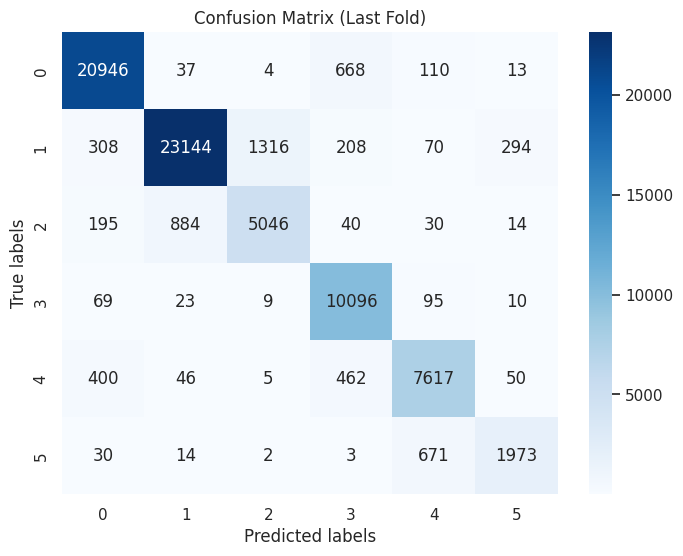

In [69]:
# Plot confusion matrix for the last fold
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Last Fold)')
plt.show()

In [70]:
# Adjust folds to match the number of splits
folds = [f"Fold {i+1}" for i in range(len(precision_scores))]

# Create the DataFrame
metrics_df = pd.DataFrame({
    'Fold': folds,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores,
    'MCC': mcc_scores
})

In [71]:
# Set the background color and theme
background_color = '#e2f0fe'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

### PRF Method

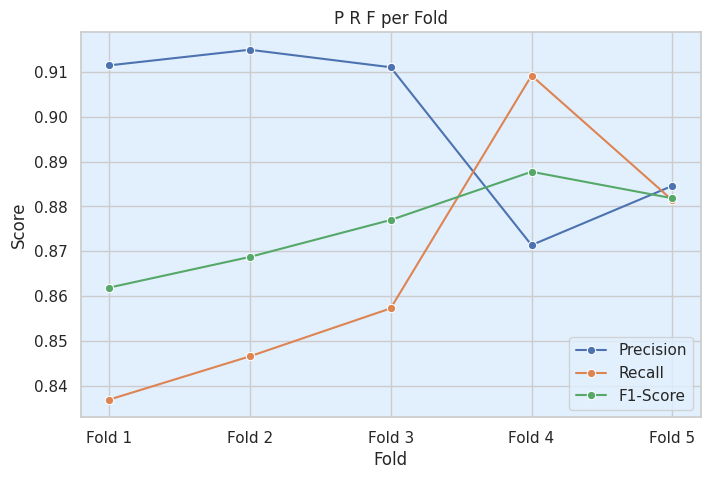

In [72]:
plt.figure(figsize=(8, 5))
# Precision, Recall, F1-Score
sns.lineplot(x='Fold', y='Precision', data=metrics_df, marker='o', label='Precision')
sns.lineplot(x='Fold', y='Recall', data=metrics_df, marker='o', label='Recall')
sns.lineplot(x='Fold', y='F1-Score', data=metrics_df, marker='o', label='F1-Score')

plt.title('P R F per Fold')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

### Matthews Correlation Coefficient

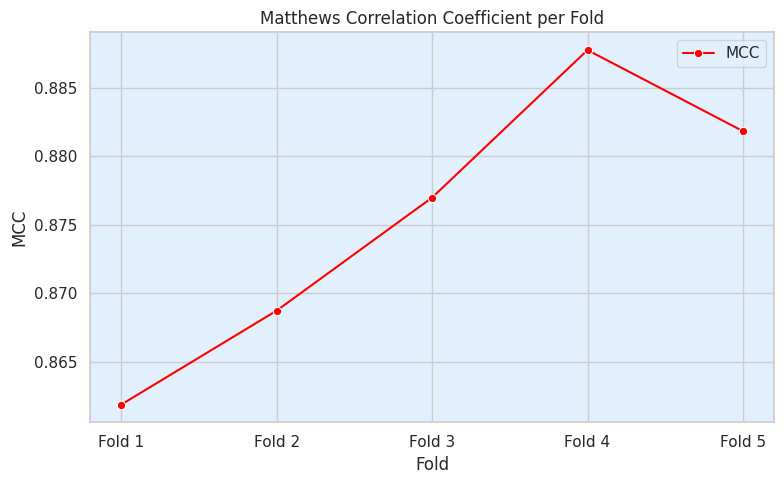

In [73]:
plt.figure(figsize=(8, 5))

# MCC
sns.lineplot(data=metrics_df, x='Fold', y='F1-Score', marker='o',label='MCC',  color='red')
plt.title('Matthews Correlation Coefficient per Fold')
plt.xlabel('Fold')
plt.ylabel('MCC')
plt.legend()
plt.tight_layout()
plt.show()

### Perplexity

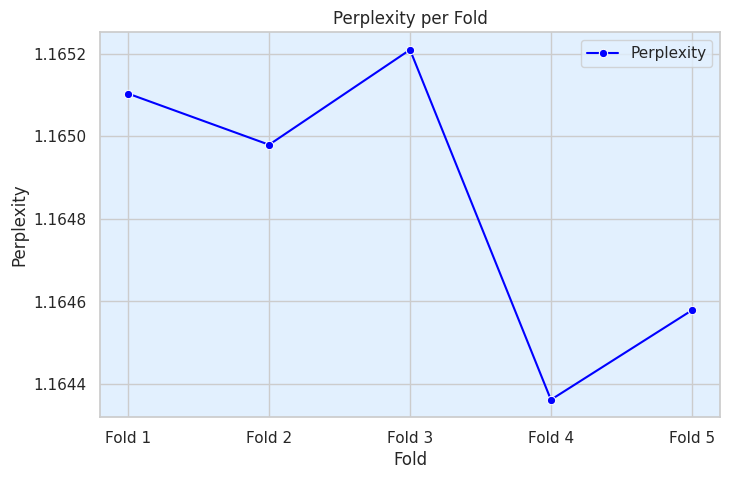

In [74]:
# Set the background color and theme
background_color = '#e2f0fe'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Perplexity plot
plt.figure(figsize=(8, 5))

sns.lineplot(x='Fold', y='Perplexity', data=pd.DataFrame({
    'Fold': folds,
    'Perplexity': np.mean([train_perplexity, val_perplexity], axis=0)
}), marker='o', label='Perplexity', color='blue')

plt.title('Perplexity per Fold')
plt.xlabel('Fold')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

### Mean and Standard Deviation

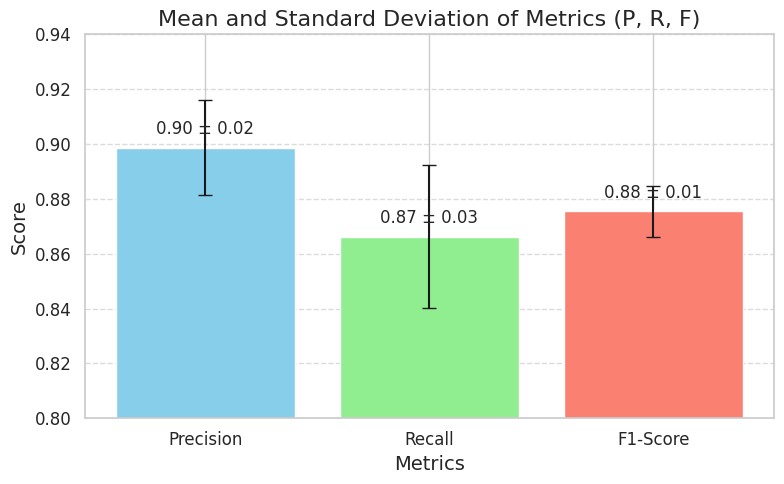

In [75]:
# Data for plotting
metrics = ['Precision', 'Recall', 'F1-Score']
mean_values = [np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)]
std_devs = [precision_std, recall_std, f1_std]

# Calculate the y-axis upper limit dynamically
max_value = max(mean + std for mean, std in zip(mean_values, std_devs))
y_upper_limit = round(max_value + 0.02, 2)  # Add a small margin for visual clarity

# Update the plot
plt.figure(figsize=(8, 5))
plt.bar(metrics, mean_values, yerr=std_devs, capsize=5, color=['skyblue', 'lightgreen', 'salmon'])

# Set title and labels with larger font size
plt.title('Mean and Standard Deviation of Metrics (P, R, F)', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metrics', fontsize=14)

# Focus y-axis on relevant range
plt.ylim(0.8, y_upper_limit)

# Customize grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars with larger font size
for i, (mean, std) in enumerate(zip(mean_values, std_devs)):
    plt.text(i, mean + 0.005, f'{mean:.2f} ± {std:.2f}', ha='center', fontsize=12)

# Set the axis background color to a light blue
plt.gca().set_facecolor('#FFFFFF')

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Result Analysis

What we are doing?

**1. model.evaluate(X_test_padded, y_test):** This line evaluates the model's performance on the test set. The method returns the loss and accuracy values computed on the test data, helping us understand how well the model is generalizing to unseen data.

**2. model.predict(X_test_padded):** This function generates predictions for the test set. The model outputs the probabilities for each class (since the final layer uses the softmax activation function for multi-class classification).

**3. np.argmax(y_pred, axis=1):** The predict() function returns probabilities for each class, but we need the predicted class label (the one with the highest probability). np.argmax() selects the index of the highest value along the specified axis (axis=1, for each sample). This gives us the predicted class labels.

In [76]:
# Evaluate Test Data
y_test = y_test.values

# Evaluates the model on the test set and returns the loss and accuracy.
model.evaluate(X_test_padded, y_test)

# Predictions On Test For Confusion Matrix
# Predicts class probabilities for the test set.
y_pred = model.predict(X_test_padded)

# Convert probabilities to class labels by selecting the index of the highest probability.
y_pred = np.argmax(y_pred, axis=1)

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9226 - loss: 0.1447
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


## Visualisation

### Confusion Matrix

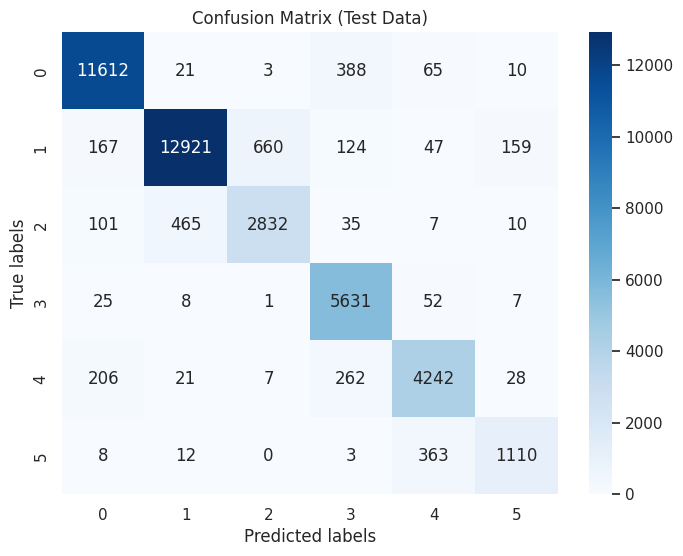

In [77]:
# Confusion Matrix for Test Data
cm_test = confusion_matrix(y_test, y_pred)

# Plot confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Test Data)')
plt.show()

### Classification Report

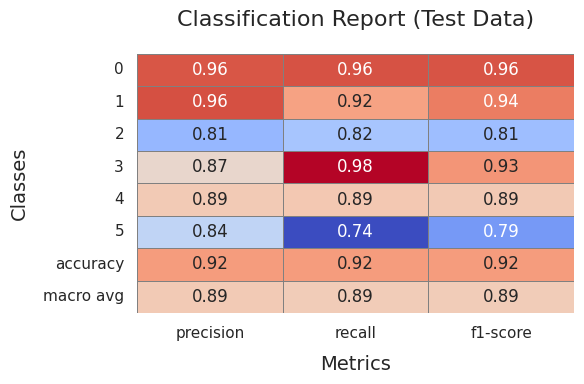

In [78]:
# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a pandas DataFrame for better formatting
report_df = pd.DataFrame(report_dict).transpose()

# Plot the classification report as a table with labels
plt.figure(figsize=(6, 4))
plt.title('Classification Report (Test Data)', fontsize=16, pad=20)

# Create the table with a heatmap style
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", cbar=False, fmt=".2f", linewidths=0.5, linecolor='gray')

# Add axis labels
plt.xlabel("Metrics", fontsize=14, labelpad=10)
plt.ylabel("Classes", fontsize=14, labelpad=10)

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()

### Correct vs Incorrect Predictions per Class

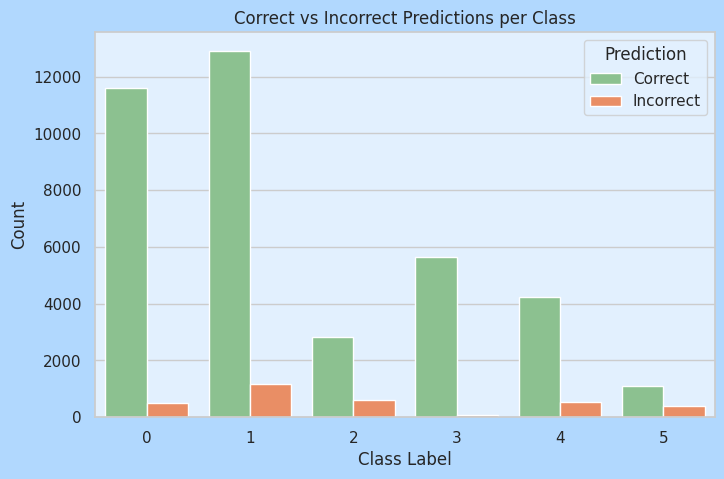

In [79]:
# Boolean array for correct predictions
correct_predictions = (y_pred == y_test)

# DataFrame for analysis
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred,
    'Correct': correct_predictions
})

# Group by 'True Label' to calculate correct and incorrect counts
grouped_data = results_df.groupby('True Label').agg(
    Correct=('Correct', 'sum'),  # Count of correct predictions
    Total=('Correct', 'size')   # Total predictions for the class
).reset_index()

# Calculate incorrect predictions
grouped_data['Incorrect'] = grouped_data['Total'] - grouped_data['Correct']

# Rename column for clarity
grouped_data.rename(columns={'True Label': 'Class Label'}, inplace=True)

# Reshape the data using pd.melt for Seaborn compatibility
plot_data = pd.melt(
    grouped_data,
    id_vars='Class Label',
    value_vars=['Correct', 'Incorrect'],
    var_name='Prediction',
    value_name='Count'
)

# Plot using Seaborn
plt.figure(figsize=(8, 5))

# Set the axis background color to a light blue
plt.gca().set_facecolor('#e2f0fe')

sns.barplot(
    x='Class Label',
    y='Count',
    hue='Prediction',
    data=plot_data,
    palette={'Correct': '#83ca89', 'Incorrect': '#ff864f'}
)

plt.gcf().set_facecolor('#b1d8fe')  # Set figure background color

# Customize the plot
plt.title('Correct vs Incorrect Predictions per Class')
plt.ylabel('Count')
plt.xlabel('Class Label')
plt.legend(title='Prediction')
plt.show()

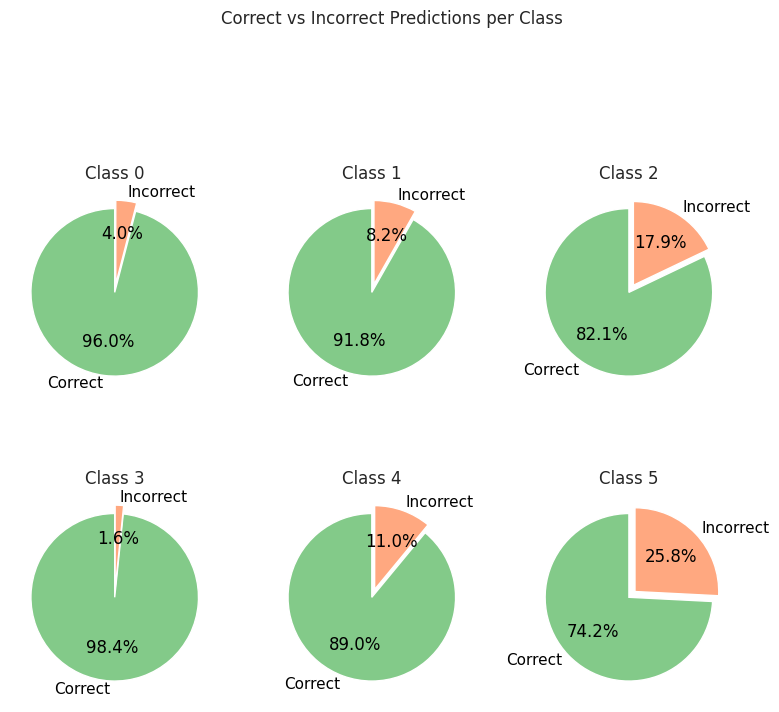

In [80]:
# Group by 'True Label' to calculate correct and incorrect counts
grouped_data = results_df.groupby('True Label').agg(
    Correct=('Correct', 'sum'),  # Count of correct predictions
    Total=('Correct', 'size')    # Total predictions for the class
).reset_index()

# Calculate incorrect predictions
grouped_data['Incorrect'] = grouped_data['Total'] - grouped_data['Correct']

# Rename column for clarity
grouped_data.rename(columns={'True Label': 'Class Label'}, inplace=True)

# Set the number of columns in a row
columns_per_row = 3
# Calculate the number of rows needed for the subplots
n_rows = (len(grouped_data) + columns_per_row - 1) // columns_per_row  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, columns_per_row, figsize=(8, 4 * n_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create a pie chart for each class
for i, (class_label, row) in enumerate(grouped_data.iterrows()):
    # Data for the pie chart (correct, incorrect)
    sizes = [row['Correct'], row['Incorrect']]
    labels = ['Correct', 'Incorrect']

    # Light colors for correct and incorrect predictions
    colors = ['#83ca89', '#ffa880']  # Light Green for correct, Light Red for incorrect

    # Explode effect: making 'Incorrect' slice pop out
    explode = (0, 0.1)  # 0.1 for 'Incorrect' slice to explode

    # Plot the pie chart for the current class
    axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'color': 'black'}, explode=explode)
    axes[i].set_title(f'Class {class_label}')

# Remove any unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Set overall title
plt.suptitle('Correct vs Incorrect Predictions per Class', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### ROC-AUC Curve

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


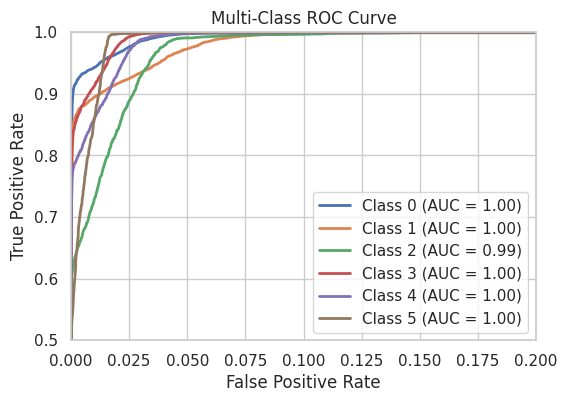

In [81]:
# Ensure `y_test` is one-hot encoded
if y_test.ndim == 1:
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)

# Predict class probabilities
y_pred_prob = model.predict(X_test_padded)

# Number of classes
n_classes = y_test.shape[1]

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, label=f"Class {i} (AUC = {roc_auc:.2f})", linewidth=2)

# Set axis limits to zoom in
plt.xlim(0.0, 0.2)
plt.ylim(0.5, 1.0)

# Add labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Calibration Curve

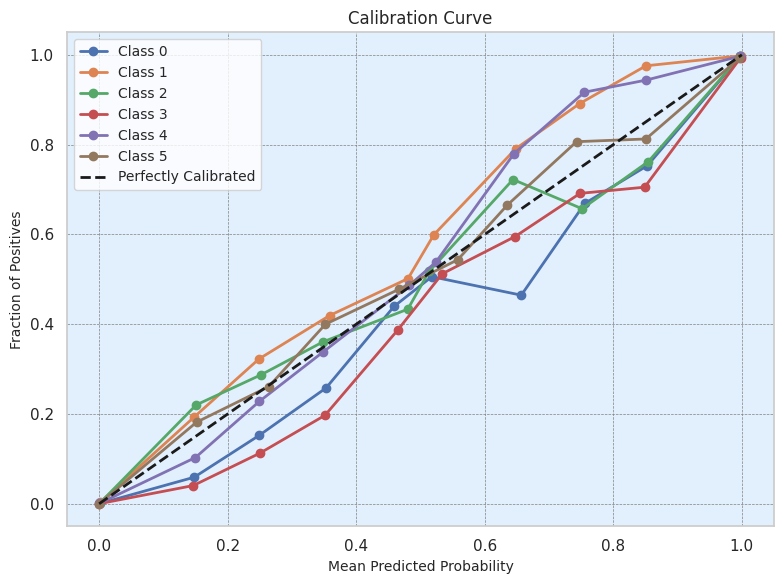

In [82]:
# Calibration Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_test[:, i], y_pred_prob[:, i], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f"Class {i}", linewidth=2)

# Set the axis background color to a light blue
plt.gca().set_facecolor('#e2f0fe')

# Add a reference diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated", linewidth=2)

# Add title, labels, and legend
plt.title("Calibration Curve", fontsize=12)
plt.xlabel("Mean Predicted Probability", fontsize=10)
plt.ylabel("Fraction of Positives", fontsize=10)
plt.legend(fontsize=10, loc="best")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()